# Import

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statistics
from scipy import signal
from scipy.optimize import curve_fit
from cycler import cycler

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
#%matplotlib notebook

# Data structure

In [3]:
data_set = [{'eps': 4.0/3.0, \
               'keta' : 1.0, \
               'folder_in' : "e43/keta1/correlations/", \
               'ite' : 100, \
               'prefactor' : 10.0, \
               'N' : 64, \
               'nu' : 1.0, \
               'Sc' : 1.0}, \
                {'eps': 0.5, \
               'keta' : 1.0, \
               'folder_in' : "e05/keta1/correlations/", \
               'ite' : 100, \
               'prefactor' : 100.0, \
               'N' : 64, \
               'nu' : 1.0, \
               'Sc' : 1.0}]

In [4]:
for simu in data_set : 
    simu.update({'X' : {'direction': 'X'}, 'Y' : {'direction': 'Y'}, 'Z' : {'direction': 'Z'}})

# Read files

In [5]:
def read_correlation_file(common_folder, folder_in, file_type, quantity, iterations, direction) :
    iterations_list = list(range(iterations[0], iterations[1], iterations[2]))
    nb_of_iterations = len(iterations_list)
    for i in iterations_list :
        file = common_folder + folder_in + file_type + "_for_" + quantity + "_at_" + "%06d" % i + "_dir_" + direction + ".table"
        file_data = []
        #print('reading file: ' + file)
        averaging_weight = 1.0/nb_of_iterations
        for line in open(file) :
            temp_array_line = []
            if line[0] == '#' :          #skip commented lines
                continue
            else :
                temp_array_line=list(map(float, line.split( )))
                temp_array_line = [t * averaging_weight for t in temp_array_line]
                file_data.append(temp_array_line)  
        if (i == iterations_list[0]) : 
            accumulated_data = file_data.copy()
        else : 
            accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
    numpy_file_table = np.array(accumulated_data)
    return numpy_file_table

In [6]:
def read_scalar_spec_file(common_folder, forlder_in, quantity, spec_type, ite) :
    file = common_folder + forlder_in + quantity + "_spec_" + spec_type + "_ite=%06d" % ite + ".table"
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_data.append(temp_array_line)  
    spec_table = np.array(file_data)
    #k = spec_table[:,0]
    #nb_of_modes = spec_table[:,1]
    Es = spec_table[:,2]
    return Es

In [7]:
def read_spec_file(common_folder, forlder_in, quantity, spec_type, ite) :
    file = common_folder + forlder_in + quantity + "_spec_" + spec_type + "_ite=%06d" % ite + ".table"
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_data.append(temp_array_line)  
    spec_table = np.array(file_data)
    k = spec_table[:,0]
    nb_of_modes = spec_table[:,1]
    Ek = spec_table[:,2]
    Exx = spec_table[:,3]
    Eyy = spec_table[:,4]
    Ezz = spec_table[:,5]
    return [k, nb_of_modes, Ek, Exx, Eyy, Ezz, spec_table[:,6], spec_table[:,7], spec_table[:,8], spec_table[:,9]]
# return [k, nb_of_modes, Ek]

In [8]:
def read_flow_stat(common_folder, forlder_in, simu) :
    file = common_folder + forlder_in + "Flow_stat.out"
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            try :
                temp_array_line=list(map(float, line.split( )))
                file_data.append(temp_array_line)  
            except : 
                temp_array_line = ''        
    spec_table = np.array(file_data)[1::]
    simu.update({'time': spec_table[:,0], 'e_kine' : spec_table[:,1], 'lambda' : spec_table[:,2], 'Re_lambda' : spec_table[:,3], 'epsilon' : spec_table[:,4], \
                 'eta': spec_table[:,5], 'u^2' : spec_table[:,6], 'v^2' : spec_table[:,7], 'w^2' : spec_table[:,8], \
                 'du/dx^2' : spec_table[:,9], 'dv/dy^2' : spec_table[:,10], 'dw/dz^2' : spec_table[:,11], 'skewness_u' : spec_table[:,12], \
                 'flatness_u' : spec_table[:,13], 'skewness_deriv': spec_table[:,14], 'enstrophy' : spec_table[:,15], 'helicity' : spec_table[:,16]})
    return spec_table

In [9]:
common_folder = "/home/gorbunov8a/CODE/random_advection_test/"
for simu in data_set : 
    # Read kinetic energy spectra
    [simu['k'], simu['nb_of_modes'], simu['Ek'], simu['Exx'], simu['Eyy'], simu['Ezz'], simu['Var'], simu['Varxx'], simu['Varyy'], simu['Varzz']] = read_spec_file(common_folder, \
                                                                                                                                                   simu['folder_in'], "vel", "lin", simu['ite'])
    #  Read scalar spectra
    simu['Es'] = read_scalar_spec_file(common_folder, simu['folder_in'], "scalar", "lin", simu['ite'])
    for direction in {'X', 'Y', 'Z'} :
        # Read scalar structure functions  
        table = read_correlation_file(common_folder, simu['folder_in'], "structFonc02thOrder", "scalar", [1, simu['ite'], 1], direction)
        simu.update({'r' : table[:,0]})
        simu[direction].update({'S2_scal' : table[:,1]})
        # Read Real space velocity correlations
        try :
            table = read_correlation_file(common_folder, simu['folder_in'], "twoPointCorr", "velo", [1, simu['ite'], 1], direction)
            simu[direction].update({'XX' : table[:,1]})
            simu[direction].update({'YY' : table[:,2]})
            simu[direction].update({'ZZ' : table[:,3]})
            simu[direction].update({'XY' : table[:,4]})
            simu[direction].update({'XZ' : table[:,5]})
            simu[direction].update({'YZ' : table[:,6]})                                    
        except : 
            print('Velocity correlation file not found')
        # Read flow parameters
        #read_flow_stat(common_folder, simu['folder_in'], simu)

Velocity correlation file not found
Velocity correlation file not found
Velocity correlation file not found
Velocity correlation file not found
Velocity correlation file not found
Velocity correlation file not found


# Parameters

In [10]:
def find_D0(prefactor, nu, eps, Sc, N, keta) :
    return [prefactor*4.0*nu*eps/Sc*((2.0*keta/N)**(-eps)), np.pi*N/keta]

In [11]:
m=1.0

for simu in data_set : 
    simu['D0'] = find_D0(simu['prefactor'], simu['nu'], simu['eps'], simu['Sc'], simu['N'], simu['keta'])[0]
    simu['spherical_coef'] = 4.0*np.pi*simu['k']**2/simu['nb_of_modes']

# Plottiong options

In [12]:
plt.rc('axes', labelsize=16)  
plt.rc('axes', titlesize=16)  
plt.rc('legend', fontsize=14)  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
default_cycler = cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors))
plt.rc('axes', prop_cycle=default_cycler)

# Velocity spectra

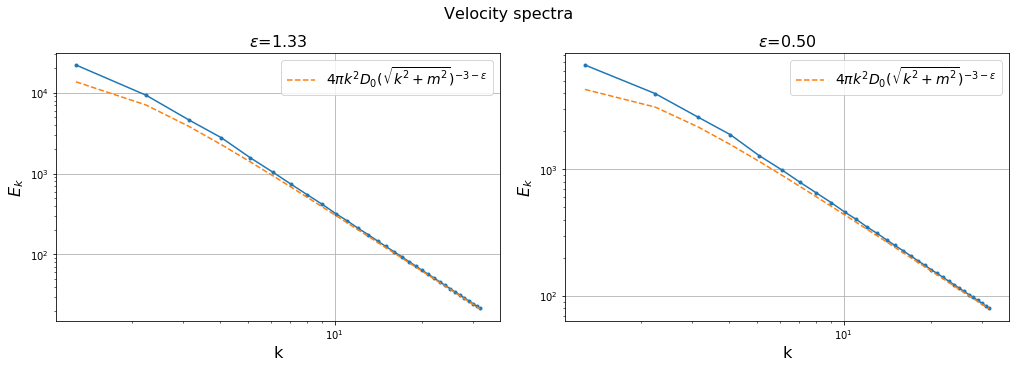

In [13]:
def theor_spec_vel(eps_scaling, k) :
    return 4.0*np.pi*k*k*(np.sqrt(k**2+m**2))**(-3.0-eps_scaling)

fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(5*len(data_set)+4,5))
fig.suptitle(r'Velocity spectra', size=16) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    ax[i].plot(simu['k'], simu['Ek']*simu['spherical_coef'], '.-')
    ax[i].plot(simu['k'], simu['D0']*theor_spec_vel(simu['eps'], simu['k']), '--', label=r'$4\pi k^2 D_0 (\sqrt{k^2+m^2})^{-3-\epsilon}$')
    ax[i].set(xscale='log', yscale='log', title=r'$\epsilon$=%2.2f' % (simu['eps']), xlabel='k', ylabel=r'$E_k$'); ax[i].grid()
    ax[i].legend()
plt.show()

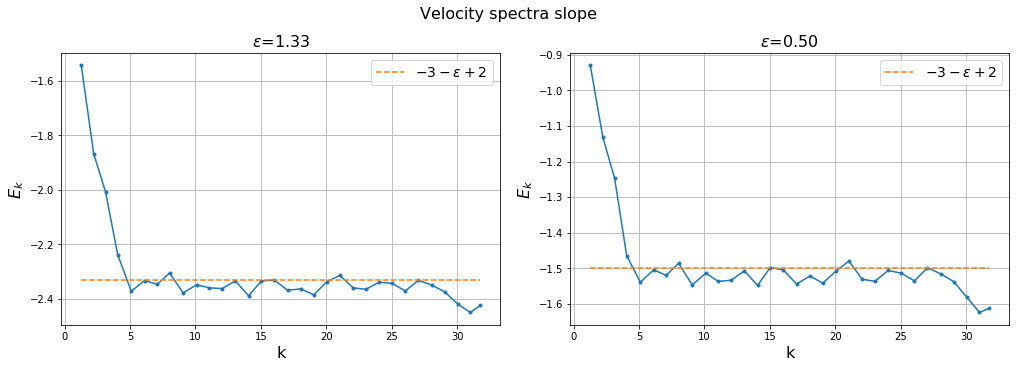

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(5*len(data_set)+4,5))
fig.suptitle(r'Velocity spectra slope', size=16) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    ax[i].plot(simu['k'], np.gradient(np.log(simu['Ek']*simu['spherical_coef']), np.log(simu['k'])), '.-')
    ax[i].plot(simu['k'], np.full_like(simu['k'], -1.0-simu['eps']), '--', label=r'$-3-\epsilon + 2$')
    ax[i].set(xscale='linear', yscale='linear', title=r'$\epsilon$=%2.2f' % (simu['eps']), xlabel='k', ylabel=r'$E_k$'); ax[i].grid()
    ax[i].legend()
plt.show()

# Scalar spectra

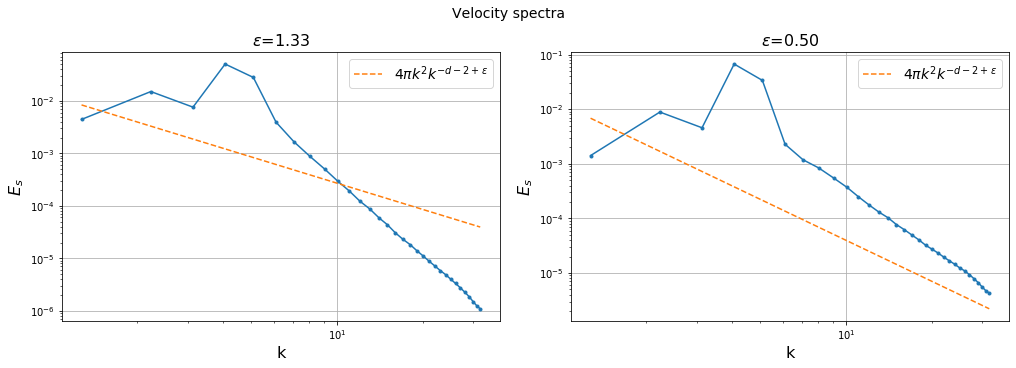

In [15]:
def theor_spec_scal(eps_scaling, k) :
    return 4.0*np.pi*k*k*(np.sqrt(k**2))**(-3.0-2.0+eps_scaling)

fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(5*len(data_set)+4,5))
fig.suptitle(r'Velocity spectra', size=14) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    ax[i].plot(simu['k'], simu['Es']*simu['spherical_coef'], '.-')
    ax[i].plot(simu['k'], 10e-4*theor_spec_scal(simu['eps'], simu['k']), '--', label=r'$4\pi k^2 k^{-d-2+\epsilon}$')
    ax[i].set(xscale='log', yscale='log', title=r'$\epsilon$=%2.2f' % (simu['eps']), xlabel='k', ylabel=r'$E_s$'); ax[i].grid()
    ax[i].legend()
plt.show()

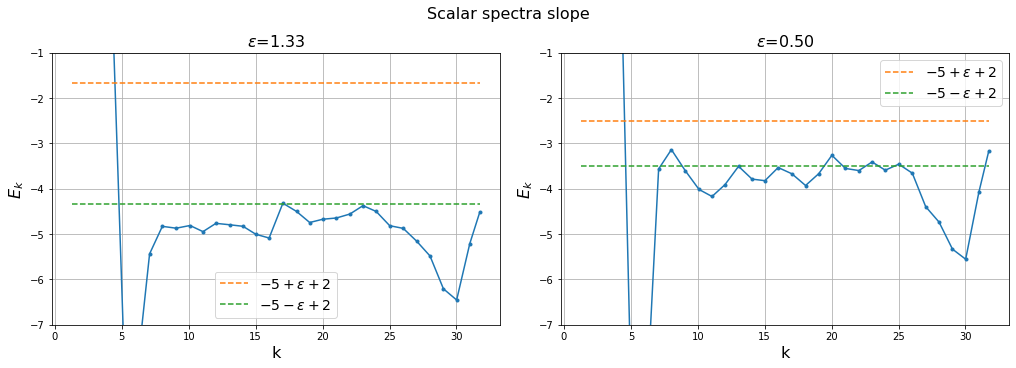

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(5*len(data_set)+4,5))
fig.suptitle(r'Scalar spectra slope', size=16) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    ax[i].plot(simu['k'], np.gradient(np.log(simu['Es']*simu['spherical_coef']), np.log(simu['k'])), '.-')
    ax[i].plot(simu['k'], np.full_like(simu['k'], -5.0+simu['eps']+2), '--', label=r'$-5+\epsilon + 2$')
    ax[i].plot(simu['k'], np.full_like(simu['k'], -5.0-simu['eps']+2), '--', label=r'$-5-\epsilon + 2$')
    ax[i].set(xscale='linear', yscale='linear', title=r'$\epsilon$=%2.2f' % (simu['eps']), xlabel='k', ylabel=r'$E_k$'); ax[i].grid()
    ax[i].set(ylim=[-7,-1])
    ax[i].legend()
plt.show()

# Scalar structure functions

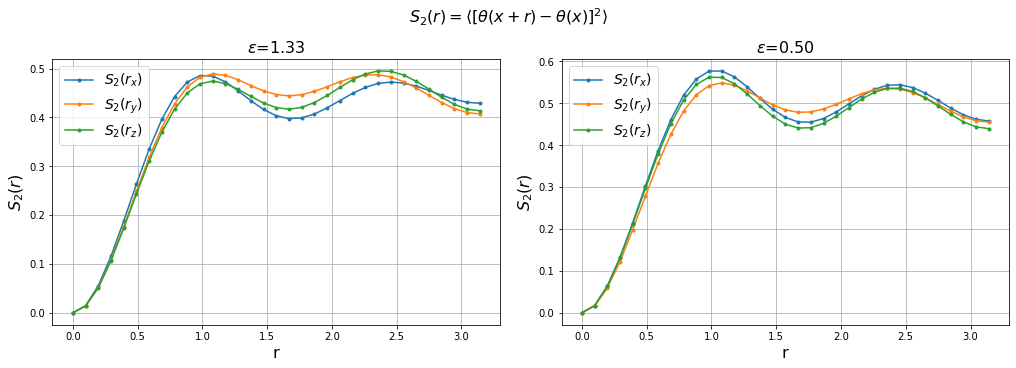

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(5*len(data_set)+4,5))
fig.suptitle(r'$S_2(r) = \left< [\theta(x + r) - \theta(x)]^2 \right>$', size=16) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    ax[i].plot(simu['r'], simu['X']['S2_scal'], '.-', label=r'$S_{2}(r_x)$')
    ax[i].plot(simu['r'], simu['Y']['S2_scal'], '.-', label=r'$S_{2}(r_y)$')
    ax[i].plot(simu['r'], simu['Z']['S2_scal'], '.-', label=r'$S_{2}(r_z)$')
    ax[i].set(xlabel='r', ylabel=r'$S_2(r)$', title=r'$\epsilon$=%2.2f' % (simu['eps'])); ax[i].grid()
    ax[i].legend()
plt.show()

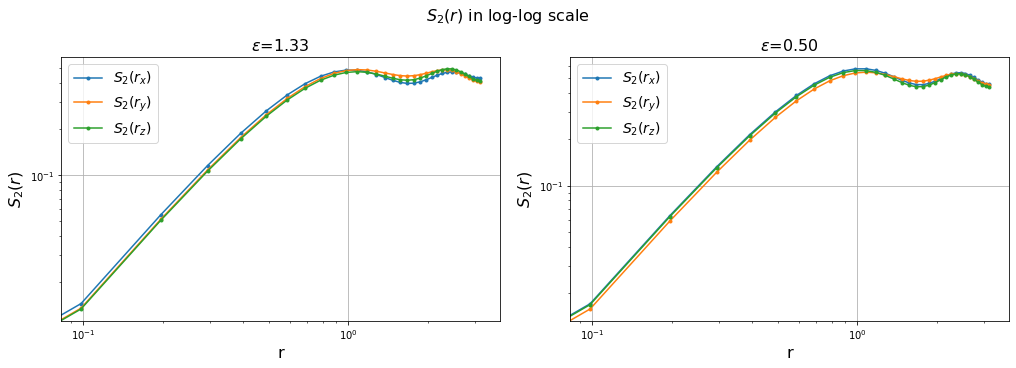

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(5*len(data_set)+4,5))
fig.suptitle(r'$S_2(r)$ in log-log scale', size=16) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    ax[i].plot(simu['r'], simu['X']['S2_scal'], '.-', label=r'$S_{2}(r_x)$')
    ax[i].plot(simu['r'], simu['Y']['S2_scal'], '.-', label=r'$S_{2}(r_y)$')
    ax[i].plot(simu['r'], simu['Z']['S2_scal'], '.-', label=r'$S_{2}(r_z)$')
#     ax[i].plot(simu['r'], 10e-9*simu['D0']*simu['r']**(2.0-simu['eps']), '--', label=r'$r^{2-\epsilon}$')
#     ax[i].plot(simu['r'], 10e-9*simu['D0']*simu['r']**(2.0), 'k--', label=r'$r^{2}$')
    ax[i].set(xscale='log', yscale='log', xlabel='r', ylabel=r'$S_2(r)$', title=r'$\epsilon$=%2.2f' % (simu['eps'])); ax[i].grid()
    ax[i].legend()
plt.show()

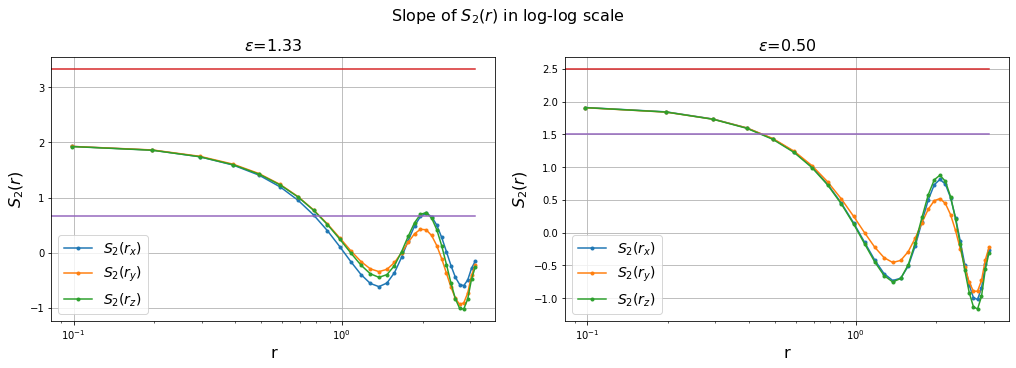

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=len(data_set), constrained_layout=True,figsize=(5*len(data_set)+4,5))
fig.suptitle(r'Slope of $S_2(r)$ in log-log scale', size=16) 
for i in list(range(len(data_set))) :
    simu = data_set[i]
    slic = slice(1,None)
    ax[i].plot(simu['r'][slic], np.gradient(np.log(simu['X']['S2_scal'][slic]), np.log(simu['r'][slic])), '.-', label=r'$S_{2}(r_x)$')
    ax[i].plot(simu['r'][slic], np.gradient(np.log(simu['Y']['S2_scal'][slic]), np.log(simu['r'][slic])), '.-', label=r'$S_{2}(r_y)$')
    ax[i].plot(simu['r'][slic], np.gradient(np.log(simu['Z']['S2_scal'][slic]), np.log(simu['r'][slic])), '.-', label=r'$S_{2}(r_z)$')
    ax[i].plot(simu['r'], np.full_like(simu['r'],2+simu['eps']))
    ax[i].plot(simu['r'], np.full_like(simu['r'],2-simu['eps']))
    ax[i].set(xscale='log', yscale='linear', xlabel='r', ylabel=r'$S_2(r)$', title=r'$\epsilon$=%2.2f' % (simu['eps'])); ax[i].grid()
    ax[i].legend()
plt.show()